# Experiments

These notebook is intended to retrieve the data from the experiments data contained in the CSV files that are generated automatically. It assumes some naming convention for the files that the user has to follow manually. The next cell contains all the code necessary for any experiment.

In [448]:
##
## MODULES
##

from matplotlib import pyplot as plt
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import os
import random

##
## GLOBAL VARIABLES
## 

contexts_file = "contexts.txt"
results_folder = "results"
images_folder = "images"

save_images = True

results_columns = [
    "TraditionalObjectUpdateTime",
    "TraditionalSceneRenderTime",
    "IndirectObjectUpdateTime",
    "IndirectMaterialUpdateTime",
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime",
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime",
    "IndirectSceneRenderTime",
    "DataGenerationTime",
    "TerrainRenderTime",
    "ObjectsPlacesGenerationTime",
    "AddedTraditionalObjects",
    "AddedIndirectObjects",
    "ChunksLoaded",
    "ObjectPlacesGenerated",
]

time_columns = [
    "TraditionalObjectUpdateTime",
    "TraditionalSceneRenderTime",
    "IndirectObjectUpdateTime",
    "IndirectMaterialUpdateTime",
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime",
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime",
    "IndirectSceneRenderTime",
    "DataGenerationTime",
    "TerrainRenderTime",
    "ObjectsPlacesGenerationTime",
]

traditional_time_columns = [
    "TraditionalObjectUpdateTime",
    "TraditionalSceneRenderTime"
]

indirect_update_time_columns = [
    "IndirectObjectUpdateTime",
    "IndirectMaterialUpdateTime"
]

indirect_batch_time_columns = [
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime"
]

indirect_buffer_time_columns = [
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime"
]

indirect_time_columns = [
    "IndirectObjectUpdateTime",
    "IndirectMaterialUpdateTime",
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime",
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime",
    "IndirectSceneRenderTime"
]

##
## GLOBAL FUNCTIONS
##

def get_contexts():
    file_path = os.path.join('contexts.txt')
    contexts = []
    
    with open(file_path, 'r') as file:
        content = file.read().strip().split('@@@@@@@@')
        
        for context in content:
            if len(context) == 0:
                continue
            
            context_dict = {}
            
            for line in context.split('\n'):
                if line.strip():
                    key, value = line.split(':', 1)
                    context_dict[key.strip()] = value.strip()
                    
            contexts.append(context_dict)
            
    return contexts

def get_results(contexts):
    for context in contexts:
        result_path = context.get("ResultPath")
        if result_path and os.path.exists(result_path):
            context["Result"] = pd.read_csv(result_path)
            context["Result"].columns = results_columns
        else:
            context["Result"] = None
    return contexts

def cast_int_contexts(contexts, key):
    for context in contexts:
        context[key] = int(context[key])
    

def filter_contexts(contexts, key, value):
    filtered_contexts = []
    
    for context in contexts:
        if context[key] == value:
            filtered_contexts.append(context)
            
    return filtered_contexts

def filter_contexts_k(contexts, key1, key2):
    filtered_contexts = []
    
    for context in contexts:
        if context[key1] == context[key2]:
            filtered_contexts.append(context)
            
    return filtered_contexts
    

def get_merged_contexts_results(contexts, merge_column_name):
    dataframes = []

    for context in contexts:
        context["Result"][merge_column_name] = context[merge_column_name]
        dataframes.append(context["Result"])

    if len(contexts) > 0:
        merged_df = pd.concat(dataframes, ignore_index=True)
        merged_df = merged_df[[merge_column_name] + results_columns]
    
        return merged_df
    
    raise Exception("get_merged_contexts_results: no contexts provided") 

def get_mili_times_df(df):
    for col in time_columns:
        if col in df.columns:
            df[col] = (df[col] / 1000).round(2)

def add_sum_column(df, column_name, columns_to_sum):
    df[column_name] = df[columns_to_sum].sum(axis=1)
    return df

def add_division_denominator_column(df, column_name, enumerator, denominator_column):
    df[column_name] = (enumerator / df[denominator_column])

##
## PLOTING FUNCTIONS
##

def generate_line_plot(dfs, column, labels, title, xlabel, ylabel, log2scale=False):
    fig, ax = plt.subplots()

    for i in range(len(dfs)):
        ax.plot(dfs[i].index, dfs[i][column], label=labels[i])
        
    if log2scale:
        ax.set_xscale('log', base=2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if len(labels) > 1:
        ax.legend()
    
    plt.title(title)

    if save_images:
        log2scale_text = "-Log2" if log2scale else ""
        plt.savefig(images_folder + "/" + title + log2scale_text + ".png")
    
    plt.show()

def generate_bar_plot(values, samples, labels, title, xlabel, ylabel, log2labels=True):
    colors = ["#83C11D", "#F39C16", "#38CCCC"]
    
    n_groups = len(samples)
    n_bars = len(values)
    
    bar_width = 0.35
    index = np.arange(n_groups)

    fig, ax = plt.subplots()

    for i, value in enumerate(values):
        ax.bar(index + i * bar_width, value, bar_width, label=labels[i], color=colors[i % len(colors)])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(index + bar_width / n_bars)
    
    if log2labels:
        formatted_samples = [f'$2^{{{int(np.log2(sample))}}}$' for sample in samples]
        ax.set_xticklabels(formatted_samples)
    else:
        ax.set_xticklabels(samples)
    
    ax.legend()

    if save_images:
        plt.savefig(images_folder + "/" + title + ".png")
    
    plt.show()


def generate_pie_plot(values, labels, title):
    colors = ["#83C11D", "#38CCCC", "#F39C16", "#E477CD", "#FFC500", "#43AFFF"]
    #random.shuffle(colors)

    threshold = 0.01
    indices = [i for i, v in enumerate(values) if v / sum(values) >= threshold]
    values = [values[i] for i in indices]
    labels = [labels[i] for i in indices]
    
    #plt.figure(figsize=(10, 7))
    plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    
    if save_images:
        plt.savefig(images_folder + "/" + title + ".png")
    
    plt.show()

##
## GLOBAL LOGIC
##

contexts = get_contexts()

get_results(contexts)

print(f"Loaded {len(contexts)} experiment contexts successfully")


Loaded 59 experiment contexts successfully


## Objects

Average statistics per frame when running an application with a permanent amount of objects

In [333]:
experiment = "Objects"

experiment_contexts = filter_contexts(contexts, "Experiment", experiment)

cast_int_contexts(experiment_contexts, "NumberOfObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingTransformObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingMeshObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingMaterialObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingMaterialTypeObjects")

### No Changing Objects

Experiments with an static amount of objects that don't suffer any type of change

Maximum traditional time: 80738.64
Maximum indirect time: 6070.85
Speedup: 13.299396295411679


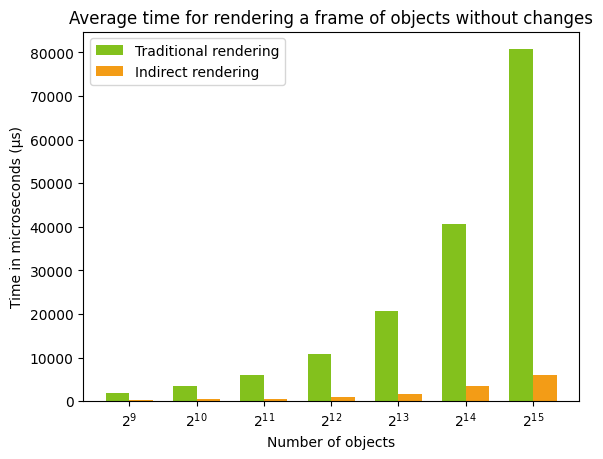

In [373]:
no_changing_contexts = filter_contexts(experiment_contexts, "NumberOfChangingTransformObjects", 0)
no_changing_contexts = filter_contexts(no_changing_contexts, "NumberOfChangingMeshObjects", 0)
no_changing_contexts = filter_contexts(no_changing_contexts, "NumberOfChangingMaterialObjects", 0)
no_changing_contexts = filter_contexts(no_changing_contexts, "NumberOfChangingMaterialTypeObjects", 0)

no_changing_traditional_contexts = filter_contexts(no_changing_contexts, "ObjectRenderingMethod", "Traditional")
no_changing_indirect_contexts = filter_contexts(no_changing_contexts, "ObjectRenderingMethod", "Indirect")


no_changing_traditional_results = get_merged_contexts_results(no_changing_traditional_contexts, "NumberOfObjects")
no_changing_indirect_results = get_merged_contexts_results(no_changing_indirect_contexts, "NumberOfObjects")

no_traditional_avg = no_changing_traditional_results.groupby("NumberOfObjects").mean()
no_indirect_avg = no_changing_indirect_results.groupby("NumberOfObjects").mean()

add_sum_column(no_traditional_avg, "FrameTime", traditional_time_columns)
add_division_denominator_column(no_traditional_avg, "FPS", 1_000_000, "FrameTime")

add_sum_column(no_indirect_avg, "UpdateTime", indirect_update_time_columns)
add_sum_column(no_indirect_avg, "BatchBuildTime", indirect_batch_time_columns)
add_sum_column(no_indirect_avg, "BufferRefreshTime", indirect_buffer_time_columns)
add_sum_column(no_indirect_avg, "FrameTime", indirect_time_columns)
add_division_denominator_column(no_indirect_avg, "FPS", 1_000_000, "FrameTime")

print("Maximum traditional time:", no_traditional_avg['FrameTime'].max().round(2))
print("Maximum indirect time:", no_indirect_avg['FrameTime'].max().round(2))
print("Speedup:", no_traditional_avg['FrameTime'].max().round(2) / no_indirect_avg['FrameTime'].max().round(2))

no_number_of_objects = no_traditional_avg.index.tolist()
no_times = [no_traditional_avg['FrameTime'].tolist(), no_indirect_avg['FrameTime'].tolist()]
no_labels = ["Traditional rendering", "Indirect rendering"]

generate_bar_plot(no_times,
                  no_number_of_objects,
                  no_labels,
                  "Average time for rendering a frame of objects without changes",
                  "Number of objects",
                  "Time in microseconds (μs)")



### Transform Changing Objects

Maximum traditional time: 195202.25
Maximum indirect time: 144479.98
Speedup: 1.3510678088410588


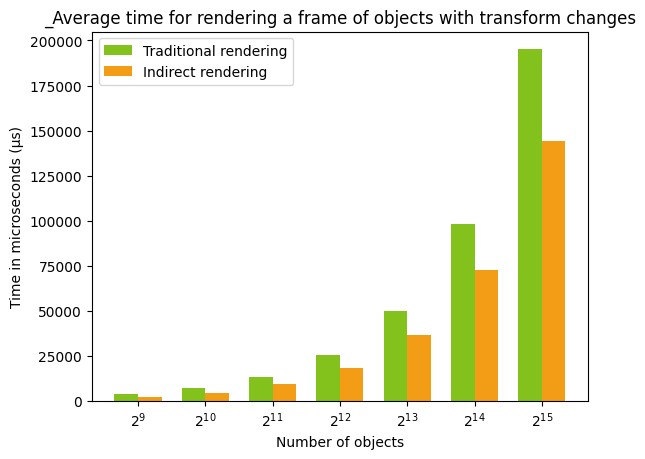

Maximum NU traditional time: 81011.5
Maximum NU indirect time: 28641.09
Speedup NU: 2.828506177662931


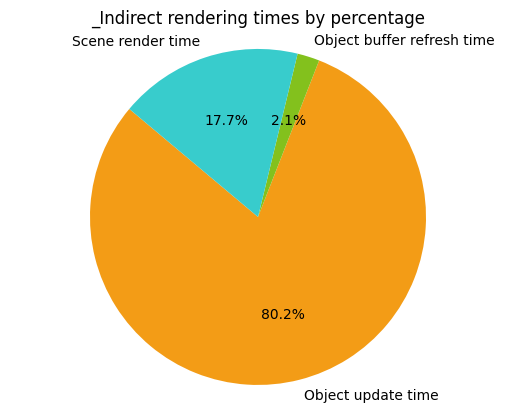

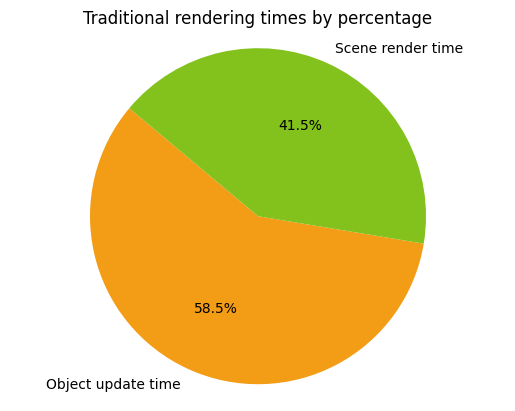

In [413]:
tr_changing_contexts = filter_contexts_k(experiment_contexts, "NumberOfObjects", "NumberOfChangingTransformObjects")

tr_changing_traditional_contexts = filter_contexts(tr_changing_contexts, "ObjectRenderingMethod", "Traditional")
tr_changing_indirect_contexts = filter_contexts(tr_changing_contexts, "ObjectRenderingMethod", "Indirect")

tr_changing_traditional_results = get_merged_contexts_results(tr_changing_traditional_contexts, "NumberOfObjects")
tr_changing_indirect_results = get_merged_contexts_results(tr_changing_indirect_contexts, "NumberOfObjects")

tr_traditional_avg = tr_changing_traditional_results.groupby("NumberOfObjects").mean()
tr_indirect_avg = tr_changing_indirect_results.groupby("NumberOfObjects").mean()


add_sum_column(tr_traditional_avg, "FrameTime", traditional_time_columns)
add_division_denominator_column(tr_traditional_avg, "FPS", 1_000_000, "FrameTime")

add_sum_column(tr_indirect_avg, "UpdateTime", indirect_update_time_columns)
add_sum_column(tr_indirect_avg, "BatchBuildTime", indirect_batch_time_columns)
add_sum_column(tr_indirect_avg, "BufferRefreshTime", indirect_buffer_time_columns)
add_sum_column(tr_indirect_avg, "FrameTime", indirect_time_columns)
add_division_denominator_column(tr_indirect_avg, "FPS", 1_000_000, "FrameTime")

tr_number_of_objects = tr_traditional_avg.index.tolist()
tr_times = [tr_traditional_avg['FrameTime'].tolist(), tr_indirect_avg['FrameTime'].tolist()]
tr_labels = ["Traditional rendering", "Indirect rendering"]

print("Maximum traditional time:", tr_traditional_avg['FrameTime'].max().round(2))
print("Maximum indirect time:", tr_indirect_avg['FrameTime'].max().round(2))
print("Speedup:", tr_traditional_avg['FrameTime'].max().round(2) / tr_indirect_avg['FrameTime'].max().round(2))

generate_bar_plot(tr_times,
                  tr_number_of_objects,
                  tr_labels,
                  "_Average time for rendering a frame of objects with transform changes",
                  "Number of objects",
                  "Time in microseconds (μs)")

add_sum_column(tr_traditional_avg, "NoUpdateFrameTime", ["TraditionalSceneRenderTime"])
add_sum_column(tr_indirect_avg, "NoUpdateFrameTime", ["BatchBuildTime", "BufferRefreshTime", "IndirectSceneRenderTime"])

print("Maximum NU traditional time:", tr_traditional_avg['NoUpdateFrameTime'].max().round(2))
print("Maximum NU indirect time:", tr_indirect_avg['NoUpdateFrameTime'].max().round(2))
print("Speedup NU:", tr_traditional_avg['NoUpdateFrameTime'].max().round(2) / tr_indirect_avg['NoUpdateFrameTime'].max().round(2))

tr_times = [tr_indirect_avg["BatchBuildTime"].iloc[-1],
            tr_indirect_avg["IndirectObjectUpdateTime"].iloc[-1],
            tr_indirect_avg["IndirectMaterialUpdateTime"].iloc[-1],
            tr_indirect_avg["IndirectIndirectBufferRefreshTime"].iloc[-1],
            tr_indirect_avg["IndirectObjectBufferRefreshTime"].iloc[-1],
            tr_indirect_avg["IndirectObjectHandleBufferRefreshTime"].iloc[-1],
            tr_indirect_avg["IndirectMaterialBufferRefreshTime"].iloc[-1],
            tr_indirect_avg["IndirectSceneRenderTime"].iloc[-1]]
tr_labels = ["Batch build time",
             "Object update time",
             "Material update time",
             "Indirect buffer refresh time",
             "Object buffer refresh time",
             "Object handle buffer refresh time",
             "Material buffer refresh time",
             "Scene render time"]

generate_pie_plot(tr_times,
                  tr_labels,
                  "_Indirect rendering times by percentage")

tr_times = [tr_traditional_avg["TraditionalObjectUpdateTime"].iloc[-1],
            tr_traditional_avg["TraditionalSceneRenderTime"].iloc[-1]]
tr_labels = ["Object update time",
             "Scene render time"]

generate_pie_plot(tr_times,
                  tr_labels,
                  "_Traditional rendering times by percentage")

### Mesh Changing Objects

Objects

Maximum traditional time: 90536.68
Maximum indirect time: 49834.97
Speedup: 1.816729898703661


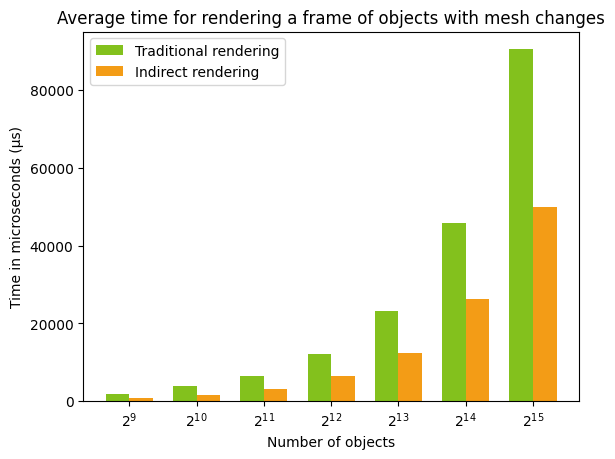

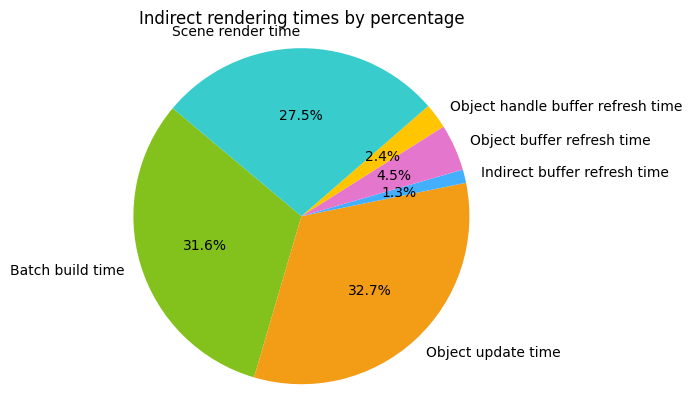

In [440]:
ms_changing_contexts = filter_contexts_k(experiment_contexts, "NumberOfObjects", "NumberOfChangingMeshObjects")

ms_changing_traditional_contexts = filter_contexts(ms_changing_contexts, "ObjectRenderingMethod", "Traditional")
ms_changing_indirect_contexts = filter_contexts(ms_changing_contexts, "ObjectRenderingMethod", "Indirect")

ms_changing_traditional_results = get_merged_contexts_results(ms_changing_traditional_contexts, "NumberOfObjects")
ms_changing_indirect_results = get_merged_contexts_results(ms_changing_indirect_contexts, "NumberOfObjects")

ms_traditional_avg = ms_changing_traditional_results.groupby("NumberOfObjects").mean()
ms_indirect_avg = ms_changing_indirect_results.groupby("NumberOfObjects").mean()


add_sum_column(ms_traditional_avg, "FrameTime", traditional_time_columns)
add_division_denominator_column(ms_traditional_avg, "FPS", 1_000_000, "FrameTime")

add_sum_column(ms_indirect_avg, "UpdateTime", indirect_update_time_columns)
add_sum_column(ms_indirect_avg, "BatchBuildTime", indirect_batch_time_columns)
add_sum_column(ms_indirect_avg, "BufferRefreshTime", indirect_buffer_time_columns)
add_sum_column(ms_indirect_avg, "FrameTime", indirect_time_columns)
add_division_denominator_column(ms_indirect_avg, "FPS", 1_000_000, "FrameTime")

ms_number_of_objects = ms_traditional_avg.index.tolist()
ms_times = [ms_traditional_avg['FrameTime'].tolist(), ms_indirect_avg['FrameTime'].tolist()]
ms_labels = ["Traditional rendering", "Indirect rendering"]

print("Maximum traditional time:", ms_traditional_avg['FrameTime'].max().round(2))
print("Maximum indirect time:", ms_indirect_avg['FrameTime'].max().round(2))
print("Speedup:", ms_traditional_avg['FrameTime'].max().round(2) / ms_indirect_avg['FrameTime'].max().round(2))

generate_bar_plot(ms_times,
                  ms_number_of_objects,
                  ms_labels,
                  "Average time for rendering a frame of objects with mesh changes",
                  "Number of objects",
                  "Time in microseconds (μs)")

ms_times = [ms_indirect_avg["BatchBuildTime"].iloc[-1],
            ms_indirect_avg["IndirectObjectUpdateTime"].iloc[-1],
            ms_indirect_avg["IndirectMaterialUpdateTime"].iloc[-1],
            ms_indirect_avg["IndirectIndirectBufferRefreshTime"].iloc[-1],
            ms_indirect_avg["IndirectObjectBufferRefreshTime"].iloc[-1],
            ms_indirect_avg["IndirectObjectHandleBufferRefreshTime"].iloc[-1],
            ms_indirect_avg["IndirectMaterialBufferRefreshTime"].iloc[-1],
            ms_indirect_avg["IndirectSceneRenderTime"].iloc[-1]]
ms_labels = ["Batch build time",
             "Object update time",
             "Material update time",
             "Indirect buffer refresh time",
             "Object buffer refresh time",
             "Object handle buffer refresh time",
             "Material buffer refresh time",
             "Scene render time"]

generate_pie_plot(ms_times,
                  ms_labels,
                  "Indirect rendering times by percentage")

### Material Changing Objects

Maximum traditional time: 82274.14
Maximum indirect time: 37865.88
Speedup: 2.1727777091143796


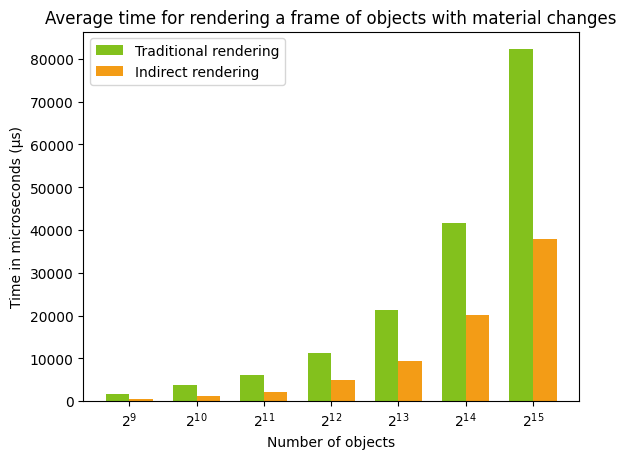

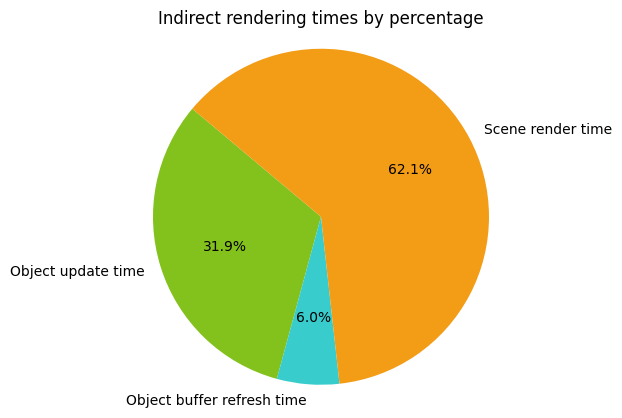

In [449]:
ma_changing_contexts = filter_contexts_k(experiment_contexts, "NumberOfObjects", "NumberOfChangingMaterialObjects")

ma_changing_traditional_contexts = filter_contexts(ma_changing_contexts, "ObjectRenderingMethod", "Traditional")
ma_changing_indirect_contexts = filter_contexts(ma_changing_contexts, "ObjectRenderingMethod", "Indirect")

ma_changing_traditional_results = get_merged_contexts_results(ma_changing_traditional_contexts, "NumberOfObjects")
ma_changing_indirect_results = get_merged_contexts_results(ma_changing_indirect_contexts, "NumberOfObjects")

ma_traditional_avg = ma_changing_traditional_results.groupby("NumberOfObjects").mean()
ma_indirect_avg = ma_changing_indirect_results.groupby("NumberOfObjects").mean()


add_sum_column(ma_traditional_avg, "FrameTime", traditional_time_columns)
add_division_denominator_column(ma_traditional_avg, "FPS", 1_000_000, "FrameTime")

add_sum_column(ma_indirect_avg, "UpdateTime", indirect_update_time_columns)
add_sum_column(ma_indirect_avg, "BatchBuildTime", indirect_batch_time_columns)
add_sum_column(ma_indirect_avg, "BufferRefreshTime", indirect_buffer_time_columns)
add_sum_column(ma_indirect_avg, "FrameTime", indirect_time_columns)
add_division_denominator_column(ma_indirect_avg, "FPS", 1_000_000, "FrameTime")

ma_number_of_objects = ma_traditional_avg.index.tolist()
ma_times = [ma_traditional_avg['FrameTime'].tolist(), ma_indirect_avg['FrameTime'].tolist()]
ma_labels = ["Traditional rendering", "Indirect rendering"]

print("Maximum traditional time:", ma_traditional_avg['FrameTime'].max().round(2))
print("Maximum indirect time:", ma_indirect_avg['FrameTime'].max().round(2))
print("Speedup:", ma_traditional_avg['FrameTime'].max().round(2) / ma_indirect_avg['FrameTime'].max().round(2))

generate_bar_plot(ma_times,
                  ma_number_of_objects,
                  ma_labels,
                  "Average time for rendering a frame of objects with material changes",
                  "Number of objects",
                  "Time in microseconds (μs)")


ma_times = [ma_indirect_avg["BatchBuildTime"].iloc[-1],
            ma_indirect_avg["IndirectObjectUpdateTime"].iloc[-1],
            ma_indirect_avg["IndirectMaterialUpdateTime"].iloc[-1],
            ma_indirect_avg["IndirectIndirectBufferRefreshTime"].iloc[-1],
            ma_indirect_avg["IndirectObjectBufferRefreshTime"].iloc[-1],
            ma_indirect_avg["IndirectObjectHandleBufferRefreshTime"].iloc[-1],
            ma_indirect_avg["IndirectMaterialBufferRefreshTime"].iloc[-1],
            ma_indirect_avg["IndirectSceneRenderTime"].iloc[-1]]
ma_labels = ["Batch build time",
             "Object update time",
             "Material update time",
             "Indirect buffer refresh time",
             "Object buffer refresh time",
             "Object handle buffer refresh time",
             "Material buffer refresh time",
             "Scene render time"]

generate_pie_plot(ma_times,
                  ma_labels,
                  "Indirect rendering times by percentage")

In [380]:
raise Exception("get_merged_contexts_results: no contexts provided") 

N_values = indirect_avg.index
batch_build_times = indirect_avg["BatchBuildTime"]
buffer_refresh_times = indirect_avg["BufferRefreshTime"]
indirect_scene_render_times = indirect_avg["IndirectSceneRenderTime"]

bar_width = 0.25
bar1 = np.arange(len(N_values))
bar2 = [x + bar_width for x in bar1]
bar3 = [x + bar_width for x in bar2]

plt.bar(bar1, batch_build_times, color='r', width=bar_width, edgecolor='grey', label="Batches build time")
plt.bar(bar2, buffer_refresh_times, color='g', width=bar_width, edgecolor='grey', label="Buffers refresh time")
plt.bar(bar3, indirect_scene_render_times, color='b', width=bar_width, edgecolor='grey', label="Render time")

# Set labels and title
plt.xlabel("Number of objects")
plt.ylabel("Time (μs)")
plt.title("Indirect rendering times by number of objects")
plt.xticks([r + bar_width for r in range(len(N_values))], N_values)
plt.legend()

#display(HTML(traditional_avg.to_html()))
#display(HTML(indirect_avg.to_html()))

##
## BAR FRAME TIME PLOT
##

bar_width = 0.25
bar1 = np.arange(len(traditional_avg.index))
bar2 = [x + bar_width for x in bar1]

# Frame Time Bar Chart
fig, ax = plt.subplots()

ax.bar(bar1, traditional_avg["FrameTime"], color='b', width=bar_width, edgecolor='grey', label='Traditional rendering')
ax.bar(bar2, indirect_avg["FrameTime"], color='r', width=bar_width, edgecolor='grey', label='Indirect rendering')

# Set labels and title
ax.set_xlabel("Number of objects")
ax.set_ylabel("Time per frame (μs)")
ax.set_title("Time per frame by number of objects")
ax.set_xticks([r + bar_width / 2 for r in range(len(traditional_avg.index))])
ax.set_xticklabels(traditional_avg.index)
ax.legend()

##
## BAR FPS PLOT
##

fig, ax = plt.subplots()

ax.bar(bar1, traditional_avg["FPS"], color='b', width=bar_width, edgecolor='grey', label='Traditional rendering')
ax.bar(bar2, indirect_avg["FPS"], color='r', width=bar_width, edgecolor='grey', label='Indirect rendering')

# Set labels and title
ax.set_xlabel("Number of objects")
ax.set_ylabel("Frames per second")
ax.set_title("Frames per second by number of objects")
ax.set_xticks([r + bar_width / 2 for r in range(len(traditional_avg.index))])
ax.set_xticklabels(traditional_avg.index)
ax.legend()


Exception: get_merged_contexts_results: no contexts provided